# 04. Transfer Learning in TensorFlow Part 1: Feature Extraction Exercises

## 1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction ([mobilenet_v2_100_224/feature_vector](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)) from TensorFlow Hub, how does it perform compared to our other models?

In [4]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data from the course github
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close

--2022-03-12 10:53:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 108.177.121.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   193MB/s    in 0.8s    

2022-03-12 10:54:00 (193 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



<bound method ZipFile.close of <zipfile.ZipFile filename='10_food_classes_10_percent.zip' mode='r'>>

In [5]:
# Setup data inputs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [6]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [7]:
# Save the tf hub model url
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to nymber of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [10]:
train_data_10_percent.num_classes

10

In [11]:
# Create mobilenet model
mobilenet_model = create_model(model_url=mobilenet_url,
                               num_classes=train_data_10_percent.num_classes)

mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [12]:
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[create_tensorboard_callback(dir_name="Tensorboard results",
                                                           experiment_name="Mobilenet")])

Saving TensorBoard log files to: Tensorboard results/Mobilenet/20220312-105758
Epoch 1/5
24/24 [==============================] - 23s 977ms/step - loss: 0.5872 - accuracy: 0.8467 - val_loss: 0.6816 - val_accuracy: 0.8004
Epoch 2/5
24/24 [==============================] - 18s 783ms/step - loss: 0.4819 - accuracy: 0.8867 - val_loss: 0.6515 - val_accuracy: 0.8044
Epoch 3/5
24/24 [==============================] - 18s 770ms/step - loss: 0.4180 - accuracy: 0.9013 - val_loss: 0.6183 - val_accuracy: 0.8080
Epoch 4/5
24/24 [==============================] - 18s 781ms/step - loss: 0.3584 - accuracy: 0.9267 - val_loss: 0.6276 - val_accuracy: 0.7972
Epoch 5/5
24/24 [==============================] - 19s 833ms/step - loss: 0.3109 - accuracy: 0.9467 - val_loss: 0.5822 - val_accuracy: 0.8172


In [15]:
# Let's create a function to plot our loss curves
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TenssorFlow History object.
  
  Returns:
    Plots of training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


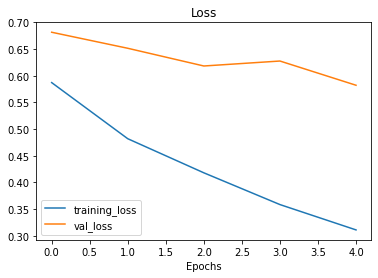

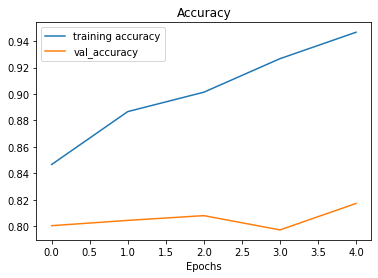

In [16]:
plot_loss_curves(mobilenet_history)

Mobilenet has veter val_accuracy than our previous Resnet model but lower than our EfficientnetB0 model, and validation and training loss and accuracy are quite different, unlike the efficientet model where they stay close.

Although val_accuracy seem to increase faster at the last epochs so more epochs could increase the accuracy faster than the previous models

## 2. Name 3 different image classification models on TensorFlow Hub that we haven't used.

* Inception_V3
* Inception_resnet_v2
* vit (Vision Transformer)

## 3. Build a model to classify images of two different things you've taken photos of.

* You can use any feature extraction layer from TensorFlow Hub you like for this.
* You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.

In [17]:
zip_ref = zipfile.ZipFile("03-CNN-exercice.zip")
zip_ref.extractall()
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='03-CNN-exercice.zip' mode='r'>>

In [ ]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("03-CNN-exercice/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from this subdirectory
print(class_names)

In [39]:
def rotate_image(image):
  return tf.image.rot90(image, k=-1)

In [40]:
import matplotlib.image as mpimg
import random
import os
def show_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)[0]
  print(random_image)
  img = mpimg.imread(target_folder + '/' + random_image)
  img = rotate_image(img)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("on")

  print(f"Image shape: {img.shape}")

  return img


IMG_20220307_124726.jpg
Image shape: (4000, 3000, 3)


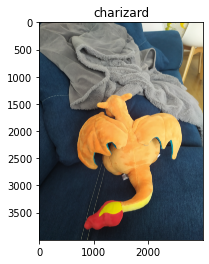

In [41]:
img = show_random_image(target_dir="03-CNN-exercice/train/",
                        target_class="charizard")

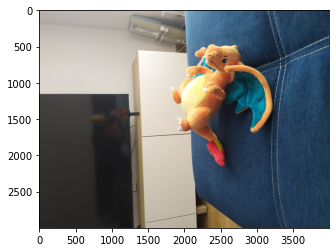

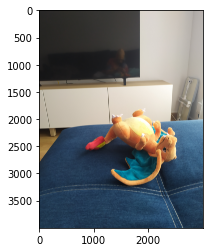

In [38]:
img = mpimg.imread("/content/03-CNN-exercice/train/charizard/IMG_20220307_124708.jpg")
plt.imshow(img)
plt.figure()
plt.imshow(tf.image.rot90(img, k=-1))

In [24]:
# Define directory paths
train_dir = "03-CNN-exercice/train/"
test_dir = "03-CNN-exercice/test/"

In [42]:
# Create train and test data generators and preprocess the images
# use our function rotate_and_flip_images as the preprocessing_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255., preprocessing_function=rotate_image)
test_datagen = ImageDataGenerator(rescale=1./255., preprocessing_function=rotate_image)

In [64]:
IMAGE_SHAPE = (224, 224)

In [65]:
# get train_data and test_data using flowfromdirectory
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               batch_size=4)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               batch_size=4)

Found 16 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [66]:
# We'll use efficientnetB0 for this exercise as it was the best performing model on the food101 dataset
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [67]:
# We can't use the create_model function as it uses softmax as the output layer activation function and we need sigmoid

def create_model_binary(model_url):
 # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1, activation="sigmoid", name="output_layer")
  ])

  return model


In [68]:
# Create the efficientnet model
efficientnet_model_binary = create_model_binary(model_url=efficientnet_url)

# Compile using binary_crossentropy
efficientnet_model_binary.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                                  optimizer=tf.keras.optimizers.Adam(),
                                  metrics=["accuracy"])

efficientnet_binary_history = efficientnet_model_binary.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=len(test_data),
                              callbacks=[create_tensorboard_callback(dir_name="Tensorboard results",
                                                           experiment_name="Efficientnet_binary")])

Saving TensorBoard log files to: Tensorboard results/Efficientnet_binary/20220312-113958
Epoch 1/5
4/4 [==============================] - 20s 2s/step - loss: 0.7719 - accuracy: 0.4375 - val_loss: 0.4877 - val_accuracy: 1.0000
Epoch 2/5
4/4 [==============================] - 5s 1s/step - loss: 0.6177 - accuracy: 0.6875 - val_loss: 0.4209 - val_accuracy: 0.7500
Epoch 3/5
4/4 [==============================] - 5s 1s/step - loss: 0.4949 - accuracy: 0.8750 - val_loss: 0.3659 - val_accuracy: 1.0000
Epoch 4/5
4/4 [==============================] - 5s 1s/step - loss: 0.4009 - accuracy: 1.0000 - val_loss: 0.3186 - val_accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 5s 1s/step - loss: 0.3178 - accuracy: 1.0000 - val_loss: 0.2764 - val_accuracy: 1.0000


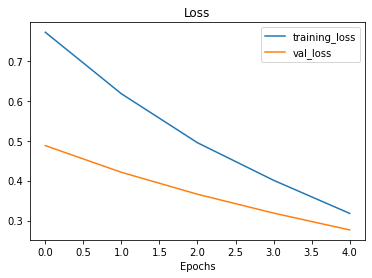

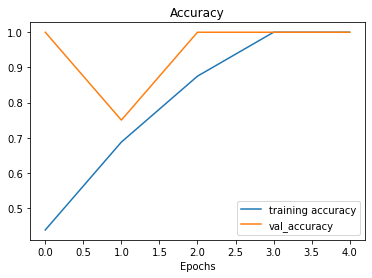

In [69]:
plot_loss_curves(efficientnet_binary_history)

Using transfer learning with efficientnet, the Charizard or Sanji model has been improved to perfection with our current data, having 100% accuracy on both training and test datasets with only 5 epochs and one trainable output layer, compared to the 75% accuracy on the test set using our own models on the previous exercises

In [70]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from a filename, turns it into a tensor and reshapes it 
  to (img_shape, img_shape, colour_channels)
  """
  # Read in the image
  img = tf.io.read_file(filename) # returns encoded image (bytes)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img) # returns decoded image (matrix)
  # Resize the image
  img = rotate_image(img)
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [71]:
# show test image and prediction
def show_image_prediction(img_path):
  image = load_and_prep_image(img_path)
  pred = efficientnet_model_binary.predict(tf.expand_dims(image, axis=0))
  pred_class=class_names[int(tf.round(pred))]
  plt.imshow(image)
  plt.title(f"This image is: {pred_class}")

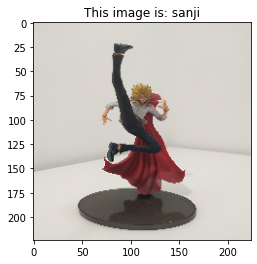

In [72]:
show_image_prediction("/content/03-CNN-exercice/test/sanji/IMG_20220307_124625.jpg")

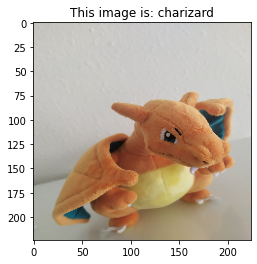

In [73]:
show_image_prediction("/content/03-CNN-exercice/test/charizard/IMG_20220307_135803.jpg")

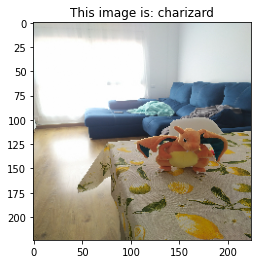

In [74]:
show_image_prediction("/content/03-CNN-exercice/test/charizard/IMG_20220307_124652.jpg")

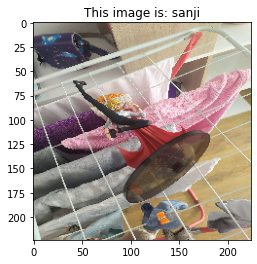

In [75]:
show_image_prediction("/content/03-CNN-exercice/test/sanji/IMG_20220307_135856.jpg")

## What is the current best performing model on ImageNet?

Currently, the best performing model on ImageNet, according to the paperwithcode website, is Model Soups (ViT-G/14) with a 90.94% accuracy
https://paperswithcode.com/sota/image-classification-on-imagenet

In [76]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir /content/Tensorboard_results/Mobilenet \
  --name "Mobilenet V2" \
  --description "Check mobilenet V2 results in the exercise" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/Tensorboard_results/Mobilenet

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=6csTFHx8aIxum5OlShB3UoMS0vudN1&prompt=co

In [77]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir /content/Tensorboard_results/Efficientnet_binary \
  --name "Efficientnet Sanji Vs Charizard" \
  --description "Check efficientnet results in the exercise on Sanji vs Charizard" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/PmYuourMQXem6aYDZS8T9A/

[2022-03-12T11:50:13] Started scanning logdir.
[2022-03-12T11:50:16] Total uploaded: 90 scalars, 0 tensors, 3 binary objects (11.7 MB)
[2022-03-12T11:50:16] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/PmYuourMQXem6aYDZS8T9A/


Check mobilenet experiment at https://tensorboard.dev/experiment/G3Ku0Y47RmCpV2XKHD3wJw/

Check efficientnet sanji vs charizard experiment at https://tensorboard.dev/experiment/PmYuourMQXem6aYDZS8T9A/